# Superposition

Last access (y.m.d): 22.09.18  
Last update (y.m.d): 20.06.10  

In this notebook, I'll look at truly testing the superposition aspect of the newer V1 experiments. In particular, for a given stimulus with dispersion > 1 (i.e. not just a single grating), the components of that stimulus will have been presented in isolation. This allows us to test $R_{1+2+..}$ against $R_1 + R_2 + ...$, where $_i$ are different stimulus components.

### Table of contents

- Example cell or experiment
   - suppression index (all conditions)  
   - sf tuning predictions   
   - rvc predictions  
- All V1 data   


In [1]:
import os
import numpy as np
import matplotlib
# matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.animation as anim
import matplotlib.cm as cm
import seaborn as sns
import itertools
import helper_fcns as hf
import autoreload
import scipy.optimize as opt
from scipy.stats.mstats import gmean as geomean

import sys # so that we can import model_responses (in different folder)

import warnings
warnings.filterwarnings('once');

%matplotlib inline

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

basePath = os.getcwd() + '/'

In [2]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 8; # this is in style sheet, just being explicit
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 5; # no minor ticks
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 0; # no minor ticks

rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.width'] = 2;
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.width'] = 0

rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

## Example cell or experiment

This section of code is used to look at just one cell or one experiment (e.g. all of V1_orig).

In this section, I outline some of the key components of the analysis and make helpful visualizations.

### Suppression index

In [9]:
## edit
expDir   = 'V1/';
dataListNm = hf.get_datalist(expDir);
# dataListNm = 'dataList_glx.npy';
descrFits_f0 = None;
if expDir == 'V1/':
    rvcMod = 1;
elif expDir == 'LGN/':
    rvcMod = 0; 

rvcName = 'rvcFitsHPC_220718' # updated - computes RVC for best responses (i.e. f0 or f1)
dFits_base = 'descrFitsHPC_220811vEs_phAdj';
# rvcName = 'rvcFits_191023' # updated - computes RVC for best responses (i.e. f0 or f1)
# dFits_base = 'descrFits_191023';
dMod_num, dLoss_num = 3, 2; # see hf.descrFit_name/descrMod_name/etc for details
dFits_mod = hf.descrMod_name(dMod_num)

descrFits_name = hf.descrFit_name(lossType=dLoss_num, descrBase=dFits_base, modelName=dFits_mod);
    
# expDir   = 'altExp/';
# dataListNm = hf.get_datalist(expDir);
# descrFits_f0 = 'descrFits_190503_poiss_flex.npy';
# rvcName = None;
# rvcnm = 'rvcFits_190905_pos.npy';
# rvcName = 'rvcFits_190905_pos.npy';

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = hf.np_smart_load(dataPath + dataListNm);
descrFits = hf.np_smart_load(dataPath + descrFits_name);

In [12]:
savePlt=0;
save_locSuper = save_loc + 'superposition_220918_fromNB/'
# save_locSuper = save_loc + 'superposition_200305/'
if not os.path.exists(save_locSuper):
    os.makedirs(save_locSuper)

In [13]:
# pick one cell? or a set?
cells = [12]; 

# or do all?
# cells = np.arange(1, 1+len(dataList['unitName']))

# or or subset of all cells?
# cells = np.setxor1d(np.arange(1, 1+len(dataList['unitName'])), np.array([2, 9, 13, 16, 18, 19, 24, 30, 29, 33, 34]))

In [14]:
zr_rm = lambda x: x[x>0];
# more flexible - only get values where x AND z are greater than some value "gt" (e.g. 0, 1, 0.4, ...)
zr_rm_pair = lambda x, z, gt: [x[np.logical_and(x>gt, z>gt)], z[np.logical_and(x>gt, z>gt)]];
# zr_rm_pair = lambda x, z: [x[np.logical_and(x>0, z>0)], z[np.logical_and(x>0, z>0)]] if np.logical_and(x!=[], z!=[])==True else [], [];

In [15]:
# here, we'll save measures we are going use for analysis purpose - e.g. supperssion index, c50
suppr_cell = dict();

In [17]:
for i in cells:
    curr_suppr = dict();
    try:
        nRows, nCols = 6, 2;
        
        which_cell = i; # which cell - index will be which_cell - 1
        cellName = dataList['unitName'][which_cell-1];
        expInd = hf.get_exp_ind(dataPath, cellName)[0]
        S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];
        
        # 0th, let's load the basic tuning characterizations AND the descriptive fit
        dfit_curr = descrFits[which_cell-1]['params'][0,-1,:]; # single grating, highest contrast
        # - then the basics
        basic_names, basic_order = dataList['basicProgName'][which_cell-1], dataList['basicProgOrder']
        basics = hf.get_basic_tunings(basic_names, basic_order)
        try:
            oriBW, oriCV = basics['ori']['bw'], basics['ori']['cv'];
        except:
            oriBW, oriCV = np.nan, np.nan;
        try:
            tfBW = basics['tf']['tfBW_oct'];
        except:
            tfBW = np.nan;
        try:
            suprMod = basics['rfsize']['suprInd_model'];
        except:
            suprMod = np.nan;
        try:
            suprDat = basics['rfsize']['suprInd_data'];
        except:
            suprDat = np.nan;
        
        ### NOW...
        try:
            cellType = dataList['unitType'][which_cell-1];
        except:
            # TODO: note, this is dangerous; thus far, only V1 cells don't have 'unitType' field in dataList, so we can safely do this                                                                                                                                                  
            cellType = 'V1';
        
        # first, compute f1f0 ratio to determine if we look at f0 or f1 response
        f1f0_rat = hf.compute_f1f0(expData, which_cell, expInd, dataPath, descrFitName_f0=descrFits_f0)[0];
        curr_suppr['f1f0'] = f1f0_rat;
        
        if f1f0_rat > 1 or expDir == 'LGN/': # i.e. if we're looking at a simple cell, then let's get F1
            if rvcName is not None:
                rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName=rvcName, rvcMod=rvcMod);
            else:
                rvcFits = None
            spikes_byComp = hf.get_spikes(expData, get_f0=0, rvcFits=rvcFits, expInd=expInd);
            spikes = np.array([np.sum(x) for x in spikes_byComp]);
            rates = True; # when we get the spikes from rvcFits, they've already been converted into rates (in hf.get_all_fft)
            baseline = None; # f1 has no "DC", yadig?
        else: # otherwise, if it's complex, just get F0
            spikes = hf.get_spikes(expData, get_f0=1, rvcFits=None, expInd=expInd);
            rates = False; # get_spikes without rvcFits is directly from spikeCount, which is counts, not rates!
            baseline = hf.blankResp(expData, expInd)[0]; # we'll plot the spontaneous rate
            # why mult by stimDur? well, spikes are not rates but baseline is, so we convert baseline to count (i.e. not rate, too)
            spikes = spikes - baseline*hf.get_exp_params(expInd).stimDur; 
        
        _, _, respOrg, respAll = hf.organize_resp(spikes, expData, expInd);
        resps, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=spikes, respsAsRates=rates);
        predResps = resps[2];
    
        respMean = resps[0]; # equivalent to resps[0];
        respStd = np.nanstd(respAll, -1); # take std of all responses for a given condition
        # compute SEM, too
        findNaN = np.isnan(respAll);
        nonNaN  = np.sum(findNaN == False, axis=-1);
        respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);

        ###########
        ### first, fit a smooth function to the overall pred V measured responses
        ### --- from this, we can measure how each example superposition deviates from a central tendency
        ### --- i.e. the residual relative to the "standard" input:output relationship
        ###########
        all_resps = respMean[1:, :, :].flatten() # all disp>0
        all_preds = predResps[1:, :, :].flatten() # all disp>0
        # a model which allows negative fits
#         myFit = lambda x, t0, t1, t2: t0 + t1*x + t2*x*x;
#         non_nan = np.where(~np.isnan(all_preds)); # cannot fit negative values with naka-rushton...
#         fitz, _ = opt.curve_fit(myFit, all_preds[non_nan], all_resps[non_nan], p0=[-5, 10, 5], maxfev=5000)
        # naka rushton - BUT automatic 0 for baseline...
        myFit = lambda x, g, expon, c50: hf.naka_rushton(x, [0, g, expon, c50]) 
        non_neg = np.where(all_preds>0) # cannot fit negative values with naka-rushton...
        fitz, _ = opt.curve_fit(myFit, all_preds[non_neg], all_resps[non_neg], p0=[100, 2, 25], maxfev=5000)
        
        ### organize stimulus information
        all_disps = stimVals[0];
        all_cons = stimVals[1];
        all_sfs = stimVals[2];

        nCons = len(all_cons);
        nSfs = len(all_sfs);
        nDisps = len(all_disps);

        maxResp = np.maximum(np.nanmax(respMean), np.nanmax(predResps));
        # by disp
        clrs_d = cm.viridis(np.linspace(0,0.75,nDisps-1));
        lbls_d = ['disp: %s' % str(x) for x in range(nDisps)];
        # by sf
        val_sfs = hf.get_valid_sfs(S, disp=1, con=val_con_by_disp[1][0], expInd=expInd) # pick 
        clrs_sf = cm.viridis(np.linspace(0,.75,len(val_sfs)));
        lbls_sf = ['sf: %.2f' % all_sfs[x] for x in val_sfs];
        # by con
        val_con = all_cons;
        clrs_con = cm.viridis(np.linspace(0,.75,len(val_con)));
        lbls_con = ['con: %.2f' % x for x in val_con];

        ### create the figure
        fSuper, ax = plt.subplots(nRows, nCols, figsize=(10*nCols, 8*nRows))
        sns.despine(fig=fSuper, offset=10)
        
        allMix = [];
        allSum = [];

        ### plot reference tuning [row 1 (i.e. 2nd row)]
        ## on the right, SF tuning (high contrast)
        sfRef = hf.nan_rm(respMean[0, :, -1]); # high contrast tuning
        ax[1, 1].plot(all_sfs, sfRef, 'k-', marker='o', label='ref. tuning (d0, high con)', clip_on=False)
        ax[1, 1].set_xscale('log')
        ax[1, 1].set_xlim((0.1, 10));
        ax[1, 1].set_xlabel('sf (c/deg)')
        ax[1, 1].set_ylabel('response (spikes/s)')
        ax[1, 1].set_ylim((-5, 1.1*np.nanmax(sfRef)));
        ax[1, 1].legend(fontsize='x-small');
        ## then on the left, RVC (peak SF)
        sfPeak = np.argmax(sfRef); # stupid/simple, but just get the rvc for the max response
        v_cons_single = val_con_by_disp[0]
        rvcRef = hf.nan_rm(respMean[0, sfPeak, v_cons_single]);
        # now, if possible, let's also plot the RVC fit
        if rvcName is not None:
            rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName=rvcName, rvcMod=rvcMod);
            rel_rvc = rvcFits[0]['params'][sfPeak]; # we get 0 dispersion, peak SF
            plt_cons = np.geomspace(all_cons[0], all_cons[-1], 50);
            if rvcMod == 0:
                rvc_mod = hf.get_rvc_model();
                c50, pk = rel_rvc[-1], rvcFits[0]['conGain'][sfPeak];
                rvcmodResp = rvc_mod(*rel_rvc, plt_cons);
            else: # i.e. mod=1 or mod=2
                c50, pk = rel_rvc[3], rvcFits[0]['conGain'][sfPeak];
                rvcmodResp = hf.naka_rushton(plt_cons, rel_rvc);
            if baseline is not None:
                rvcmodResp = rvcmodResp - baseline; 
            ax[1, 0].plot(plt_cons, rvcmodResp, 'k--', label='rvc fit (c50=%.2f, gain=%0f)' %(c50, pk))
            # and save it
            curr_suppr['c50'] = c50; curr_suppr['conGain'] = pk;

        ax[1, 0].plot(all_cons[v_cons_single], rvcRef, 'k-', marker='o', label='ref. tuning (d0, peak SF)', clip_on=False)
#         ax[1, 0].set_xscale('log')
        ax[1, 0].set_xlabel('contrast (%)');
        ax[1, 0].set_ylabel('response (spikes/s)')
        ax[1, 0].set_ylim((-5, 1.1*np.nanmax(rvcRef)));
        ax[1, 0].legend(fontsize='x-small');

        # plot the fitted model on each axis
        pred_plt = np.linspace(0, np.nanmax(all_preds), 100);
        ax[0, 0].plot(pred_plt, myFit(pred_plt, *fitz), 'r--', label='fit')
        ax[0, 1].plot(pred_plt, myFit(pred_plt, *fitz), 'r--', label='fit')

        for d in range(nDisps):
            if d == 0: # we don't care about single gratings!
                dispRats = [];
                continue; 
            v_cons = np.array(val_con_by_disp[d]);
            n_v_cons = len(v_cons);

            # plot split out by each contrast [0,1]
            for c in reversed(range(n_v_cons)):
                v_sfs = hf.get_valid_sfs(S, d, v_cons[c], expInd)
                for s in v_sfs:
                    mixResp = respMean[d, s, v_cons[c]];
                    allMix.append(mixResp);
                    sumResp = predResps[d, s, v_cons[c]];
                    allSum.append(sumResp);
        #             print('condition: d(%d), c(%d), sf(%d):: pred(%.2f)|real(%.2f)' % (d, v_cons[c], s, sumResp, mixResp))
                    # PLOT in by-disp panel
                    if c == 0 and s == v_sfs[0]:
                        ax[0, 0].plot(sumResp, mixResp, 'o', color=clrs_d[d-1], label=lbls_d[d], clip_on=False)
                    else:
                        ax[0, 0].plot(sumResp, mixResp, 'o', color=clrs_d[d-1], clip_on=False)
                    # PLOT in by-sf panel
                    sfInd = np.where(np.array(v_sfs) == s)[0][0]; # will only be one entry, so just "unpack"
                    if d == 1 and c == 0:
                        ax[0, 1].plot(sumResp, mixResp, 'o', color=clrs_sf[sfInd], label=lbls_sf[sfInd], clip_on=False);
                    else:
                        ax[0, 1].plot(sumResp, mixResp, 'o', color=clrs_sf[sfInd], clip_on=False);
                    # plot baseline, if f0...
#                     if baseline is not None:
#                         [ax[0, i].axhline(baseline, linestyle='--', color='k', label='spon. rate') for i in range(2)];


            # plot averaged across all cons/sfs (i.e. average for the whole dispersion) [1,0]
            mixDisp = respMean[d, :, :].flatten();
            sumDisp = predResps[d, :, :].flatten();
            mixDisp, sumDisp = zr_rm_pair(mixDisp, sumDisp, 0.5); # remove any values < 0.5
            curr_rats = np.divide(mixDisp, sumDisp)
            curr_mn = geomean(curr_rats); curr_std = np.std(np.log10(curr_rats));
#             curr_rat = geomean(np.divide(mixDisp, sumDisp));
            ax[2, 0].bar(d, curr_mn, yerr=curr_std, color=clrs_d[d-1]);
            ax[2, 0].set_yscale('log')
            ax[2, 0].set_ylim(0.1, 10);
#             ax[2, 0].yaxis.set_ticks(minorticks)
            dispRats.append(curr_mn);
#             ax[2, 0].bar(d, np.mean(np.divide(mixDisp, sumDisp)), color=clrs_d[d-1]);

            # also, let's plot the (signed) error relative to the fit
            errs = mixDisp - myFit(sumDisp, *fitz);
            ax[3, 0].bar(d, np.mean(errs), yerr=np.std(errs), color=clrs_d[d-1])
            # -- and normalized by the prediction output response
            errs_norm = np.divide(mixDisp - myFit(sumDisp, *fitz), myFit(sumDisp, *fitz));
            ax[4, 0].bar(d, np.mean(errs_norm), yerr=np.std(errs_norm), color=clrs_d[d-1])
            
            # and set some labels/lines, as needed
            if d == 1:
                ax[2, 0].set_xlabel('dispersion');
                ax[2, 0].set_ylabel('suppression ratio')
                ax[2, 0].axhline(1, ls='--', color='k')
                ax[3, 0].set_xlabel('dispersion');
                ax[3, 0].set_ylabel('mean (signed) error')
                ax[3, 0].axhline(0, ls='--', color='k')
                ax[4, 0].set_xlabel('dispersion');
                ax[4, 0].set_ylabel('mean (signed) error -- as frac. of fit prediction')
                ax[4, 0].axhline(0, ls='--', color='k')

            curr_suppr['supr_disp'] = dispRats;
            
        ### plot averaged across all cons/disps
        sfInds = []; sfRats = []; sfRatStd = []; 
        sfErrs = []; sfErrsStd = []; sfErrsInd = []; sfErrsIndStd = []; 
        sfErrsRat = []; sfErrsRatStd = []; # mixture response divided by NR value at that prediction
        curr_errNormFactor = [];
        for s in range(len(val_sfs)):
            try: # not all sfs will have legitmate values;
                # only get mixtures (i.e. ignore single gratings)
                mixSf = respMean[1:, val_sfs[s], :].flatten();
                sumSf = predResps[1:, val_sfs[s], :].flatten();
                mixSf, sumSf = zr_rm_pair(mixSf, sumSf, 0.5);
                rats_curr = np.divide(mixSf, sumSf); 
                sfInds.append(s); sfRats.append(geomean(rats_curr)); sfRatStd.append(np.std(np.log10(rats_curr)));
                
                curr_NR = myFit(sumSf, *fitz)
                curr_err = mixSf - curr_NR;
                sfErrs.append(np.mean(curr_err));
                sfErrsStd.append(np.std(curr_err))
                
                curr_errNorm = np.divide(mixSf - curr_NR, mixSf + curr_NR);
                sfErrsInd.append(np.mean(curr_errNorm));
                sfErrsIndStd.append(np.std(curr_errNorm))
 
                curr_errRat = np.divide(mixSf, curr_NR);
                sfErrsRat.append(np.mean(curr_errRat));
                sfErrsRatStd.append(np.std(curr_errRat));

                curr_normFactors = np.array(curr_NR)
                curr_errNormFactor.append(geomean(curr_normFactors[curr_normFactors>0]));
                
            except:
                pass
            
        # get the offset/scale of the ratio so that we can plot a rescaled/flipped version of
        # the high con/single grat tuning for reference...does the suppression match the response?
        offset, scale = np.nanmax(sfRats), np.nanmax(sfRats) - np.nanmin(sfRats);
        sfRef = hf.nan_rm(respMean[0, val_sfs, -1]); # high contrast tuning
        sfRefShift = offset - scale * (sfRef/np.nanmax(sfRef))
        ax[2,1].scatter(all_sfs[val_sfs][sfInds], sfRats, color=clrs_sf[sfInds], clip_on=False)
        ax[2,1].errorbar(all_sfs[val_sfs][sfInds], sfRats, sfRatStd, color='k', linestyle='-', clip_on=False, label='suppression tuning')
#         ax[2,1].plot(all_sfs[val_sfs][sfInds], sfRats, 'k-', clip_on=False, label='suppression tuning')
        ax[2,1].plot(all_sfs[val_sfs], sfRefShift, 'k--', label='ref. tuning', clip_on=False)
        ax[2,1].axhline(1, ls='--', color='k')
        ax[2,1].set_xlabel('sf (cpd)')
        ax[2,1].set_xscale('log')
        ax[2,1].set_xlim((0.1, 10));
#         ax[2,1].set_xlim((np.min(all_sfs), np.max(all_sfs)));
        ax[2,1].set_ylabel('suppression ratio (wrt linear)');
        ax[2,1].set_yscale('log')
#         ax[2,1].yaxis.set_ticks(minorticks)
        ax[2,1].set_ylim(0.1, 10);        
        ax[2,1].legend(fontsize='x-small');
        curr_suppr['supr_sf'] = sfRats;

        ### residuals from fit of suppression
        # mean signed error: and labels/plots for the error as f'n of SF
        ax[3,1].axhline(0, ls='--', color='k')
        ax[3,1].set_xlabel('sf (cpd)')
        ax[3,1].set_xscale('log')
        ax[3,1].set_xlim((0.1, 10));
#         ax[3,1].set_xlim((np.min(all_sfs), np.max(all_sfs)));
        ax[3,1].set_ylabel('mean (signed) error');
        ax[3,1].errorbar(all_sfs[val_sfs][sfInds], sfErrs, sfErrsStd, marker='o', color='k', linestyle='-', clip_on=False)
        # -- and normalized by the prediction output response
        ax[4,1].axhline(0, ls='--', color='k')
        ax[4,1].set_xlabel('sf (cpd)')
        ax[4,1].set_xscale('log')
        ax[4,1].set_xlim((0.1, 10));
        #         ax[4,1].set_xlim((np.min(all_sfs), np.max(all_sfs)));
        ax[4,1].set_ylim((-1, 1))
        ax[4,1].set_ylabel('mean (signed) error index');
        ax[4,1].errorbar(all_sfs[val_sfs][sfInds], sfErrsInd, sfErrsIndStd, marker='o', color='k', linestyle='-', clip_on=False)
        # -- and simply the ratio between the mixture response and the mean expected mix response (i.e. Naka-Rushton)
        # --- equivalent to the suppression ratio, but relative to the NR fit rather than perfect linear summation
        ax[5,1].scatter(all_sfs[val_sfs][sfInds], sfErrsRat, color=clrs_sf[sfInds], clip_on=False)
        ax[5,1].errorbar(all_sfs[val_sfs][sfInds], sfErrsRat, sfErrsRatStd, color='k', linestyle='-', clip_on=False, label='suppression tuning')
        ax[5,1].axhline(1, ls='--', color='k')
        ax[5,1].set_xlabel('sf (cpd)')
        ax[5,1].set_xscale('log')
        ax[5,1].set_xlim((0.1, 10));
        ax[5,1].set_ylabel('suppression ratio (wrt NR)');
        ax[5,1].set_yscale('log', basey=2)
#         ax[2,1].yaxis.set_ticks(minorticks)
        ax[5,1].set_ylim(0.1, 10);        
        ax[5,1].legend(fontsize='x-small');
        # - compute the variance!
        val_errs = np.logical_and(~np.isnan(sfErrsRat), np.logical_and(np.array(sfErrsRatStd)>0, np.array(sfErrsRatStd) < 1.25));        errsratVar = np.var(sfErrsRat);
        # - and put that value on the plot
        ax[5,1].text(0.1, 2, 'var=%.2f' % errsratVar);        
    
#         # color bar...from https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
#         def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
#             c1=np.array(mpl.colors.to_rgb(c1))
#             c2=np.array(mpl.colors.to_rgb(c2))
#             return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

        n = 500
        clrs_bar = cm.viridis(np.linspace(0,0.75, n));

        for x in range(n):
            ax[5,0].axvline(x, color=clrs_bar[x], linewidth=4) 
  
        # compute the variance for the sfErrsInd
        val_errs = np.logical_and(~np.isnan(sfErrsInd), np.logical_and(np.array(sfErrsIndStd) > 0, np.array(sfErrsIndStd) < 1.25));
        sfErrsInd_var = np.var(np.array(sfErrsInd)[val_errs])
        curr_suppr['sfErrsInd_var'] = sfErrsInd_var;
        # - and put that value on the plot
        ax[4,1].text(0.1, -0.25, 'var=%.2f' % sfErrsInd_var);

        
        #########
        ### NOW, let's evaluate the derivative of the SF tuning curve and get the correlation with the errors
        #########
        mod_sfs = np.geomspace(all_sfs[0], all_sfs[-1], 1000);
        mod_resp = hf.get_descrResp(dfit_curr, mod_sfs, DoGmodel=dMod_num);
        deriv = np.divide(np.diff(mod_resp), np.diff(mod_sfs))
        deriv_norm = np.divide(deriv, np.nanmax(deriv));
        # - then, what indices to evaluate for comparing with sfErr?
        errSfs = all_sfs[val_sfs][sfInds];
        mod_inds = [np.argmin(np.square(mod_sfs-x)) for x in errSfs];
        deriv_norm_eval = deriv_norm[mod_inds];
        # -- plot on [1, 1] (i.e. where the data is)
        ax[1,1].plot(mod_sfs, mod_resp, 'k--', label='fit (g)')
        ax[1,1].legend();
        # Duplicate "twin" the axis to create a second y-axis
        ax2 = ax[1,1].twinx();
        ax2.set_ylim([-1, 1]); # since the g' is normalized
        # make a plot with different y-axis using second axis object
        ax2.plot(mod_sfs[1:], deriv_norm, '--', color="red", label='g\'');
        ax2.set_ylabel("deriv. (normalized)",color="red")
        ax2.legend();
        sns.despine(ax=ax2, offset=10, right=False);
        # -- and let's plot rescaled and shifted version in [2,1]
        offset, scale = np.nanmax(sfRats), np.nanmax(sfRats) - np.nanmin(sfRats);
        derivShift = offset - scale * (deriv_norm/np.nanmax(deriv_norm));
        ax[2,1].plot(mod_sfs[1:], derivShift, 'r--', label='deriv(ref. tuning)', clip_on=False)
        ax[2,1].legend(fontsize='x-small');
        # - then, normalize the sfErrs/sfErrsNorm and compute the correlation coefficient
        norm_sfErr = np.divide(sfErrs, np.nanmax(np.abs(sfErrs)));
        norm_sfErrNorm = np.divide(sfErrsInd, np.nanmax(np.abs(sfErrsInd))); # remember, sfErrsNorm is normalized per condition; this is overall
        non_nan = np.logical_and(~np.isnan(norm_sfErr), ~np.isnan(deriv_norm_eval))
        corr_nsf, corr_nsfN = np.corrcoef(deriv_norm_eval[non_nan], norm_sfErr[non_nan])[0,1], np.corrcoef(deriv_norm_eval[non_nan], norm_sfErrNorm[non_nan])[0,1]
        curr_suppr['corr_derivWithErr'] = corr_nsf;
        curr_suppr['corr_derivWithErrNorm'] = corr_nsfN;
        ax[3,1].text(0.1, 0.25*np.nanmax(sfErrs), 'corr w/g\' = %.2f' % corr_nsf)
        ax[4,1].text(0.1, 0.25, 'corr w/g\' = %.2f' % corr_nsfN)          
            
        # make a polynomial fit
        hmm = np.polyfit(allSum, allMix, deg=1) # returns [a, b] in ax + b 
        curr_suppr['supr_index'] = hmm[0];

        suppr_cell[i] = curr_suppr;
        
        for j in range(1):
            for jj in range(nCols):
                ax[j, jj].axis('square')
                ax[j, jj].set_xlabel('predicted');
                ax[j, jj].set_ylabel('superposition');
                ax[j, jj].plot([0, 1*maxResp], [0, 1*maxResp], 'k--')
                ax[j, jj].set_xlim((-5, maxResp));
                ax[j, jj].set_ylim((-5, 1.1*maxResp));
                ax[j, jj].set_title('Suppression index: %.2f' % hmm[0])
                ax[j, jj].legend(fontsize='x-small');
                print('good...')

        fSuper.suptitle('Superposition: %s #%d [%s; f1f0 %.2f; szSupr[dt/md] %.2f/%.2f; oriBW|CV %.2f|%.2f; tfBW %.2f]' % (cellType, which_cell, cellName, f1f0_rat, suprDat, suprMod, oriBW, oriCV, tfBW))

        if savePlt:
            save_name = 'cell_%03d.pdf' % which_cell
            pdfSv = pltSave.PdfPages(str(save_locSuper + save_name));
            pdfSv.savefig(fSuper)
            pdfSv.close();

    except: # i.e. ignore this cell - some cells have improper data/expo files
        pass;

In [18]:
save_locSuper

'/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1/figures/superposition_220918_fromNB/'

In [19]:
save_name = 'colorbar_ex.pdf'
pdfSv = pltSave.PdfPages(str(save_locSuper + save_name));
pdfSv.savefig(fSuper)
pdfSv.close();

NameError: name 'fSuper' is not defined

#### Example for VSS poster 2020
I've picked two example points on the superposition plots and want to show the component response for the poster. I've picked V1/12, points 88 and 299 (in the overall, flattened allResps array)

In [20]:
# ex 1 of constraining the point we want - 
predConstr = np.where(np.logical_and(all_preds>45, all_preds<55));
measConstr = np.where(np.logical_and(all_resps>60, all_resps<65));
jointConstr = np.intersect1d(predConstr, measConstr)
print(jointConstr)

# ex 2 of constraining the point we want - 
predConstr = np.where(np.logical_and(all_preds>75, all_preds<85));
measConstr = np.where(np.logical_and(all_resps>50, all_resps<60));
jointConstr = np.intersect1d(predConstr, measConstr)
print(jointConstr)

# ex 3 of constraining the point we want - 
predConstr = np.where(np.logical_and(all_preds>100, all_preds<110));
measConstr = np.where(np.logical_and(all_resps>60, all_resps<65));
jointConstr = np.intersect1d(predConstr, measConstr)
print(jointConstr)


# ex 4 of constraining the point we want - 
predConstr = np.where(np.logical_and(all_preds>35, all_preds<40));
measConstr = np.where(np.logical_and(all_resps>45, all_resps<55));
jointConstr = np.intersect1d(predConstr, measConstr)
print(jointConstr)

NameError: name 'all_preds' is not defined

In [115]:
overallInd = 249; # use 88 or 299 or...., in turn
total_shape = list(respMean.shape);
# total_shape[0] = total_shape[0]
cond = np.unravel_index(overallInd, total_shape)
print(cond)

(1, 2, 15)


The above tells me what condition to look at (add +1 to the dispersion!, since we skip over single gratings in the overall all_preds & all_resps)

**ADJUST HERE ACCORDINGLY**

In [22]:
vt = hf.get_valid_trials(expData, disp=2, con=15, sf=2, expInd=expInd)[0]

NameError: name 'expData' is not defined

comps[0] is the mean predicted (and s.e.m.) response per component, comps[1] is per trial, per component

In [21]:
comps = hf.get_isolated_responseAdj(expData, vt, spikes)
perComp_resp = comps[0]; # mean
perComp_con = np.array(comps[2]).flatten();
perComp_sf = np.array(comps[3]).flatten();

# now, further separate perComp_resp!
perComp_mean = np.array([perComp_resp[x][0] for x in range(len(perComp_resp))])
perComp_sem = np.array([perComp_resp[x][1] for x in range(len(perComp_resp))])

# put them in order for plotting...
perComp_order = np.argsort(perComp_sf);

NameError: name 'expData' is not defined

In [118]:
check_sum = np.sum(perComp_mean)
print(check_sum)

102.75618864185532


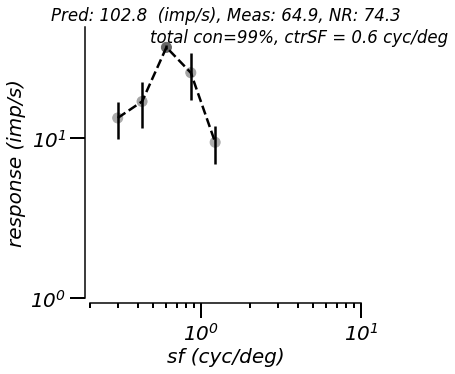

In [119]:
# plt.xscale('log');
# plt.xlim([0.1, 10]);

totalMeasure = all_resps[overallInd]
totalPred = np.sum(perComp_mean)
totalCon = np.round(100*np.sum(perComp_con), 0);
centerSF = np.round(np.median(perComp_sf), 1);

f = plt.figure(figsize=(6, 5))

nPts = 100;
clrMap = cm.gray(np.linspace(0, 0.75, nPts));
clrInds = nPts-np.round(perComp_con[perComp_order]*nPts, 0).astype(int)
plt.errorbar(perComp_sf[perComp_order], perComp_mean[perComp_order], yerr=perComp_sem[perComp_order], color='k', linestyle='--')
plt.scatter(perComp_sf[perComp_order], perComp_mean[perComp_order], color=clrMap[clrInds, :], s=100)
plt.xscale('log');
plt.yscale('log')
plt.xlim([0.2, 10])
plt.ylim([1e-0, 5e1])
plt.xlabel('sf (cyc/deg)');
plt.ylabel('response (imp/s)');
NR_resp = myFit(totalPred, *fitz)
plt.title('Pred: %.1f  (imp/s), Meas: %.1f, NR: %.1f' % (totalPred, totalMeasure, NR_resp), fontsize='small')
plt.text(np.log10(3), 40, 'total con=%d%%, ctrSF = %.1f cyc/deg' % (totalCon, centerSF), fontsize='small')
ax_curr = plt.gca();
ax_curr.set_aspect('equal')
sns.despine(offset=5);

save_name = 'superposition_ex_v1cell12_trial%d.pdf' % overallInd
pdfSv = pltSave.PdfPages(str(save_locSuper + save_name));
pdfSv.savefig(f)
pdfSv.close();

In [133]:
# m = 49.3; p = 40.4
m = 64.9; p = 74.3

In [134]:
(m-p)/(m+p)

-0.06752873563218385

#### Back to regularly scheduled programming

In [ ]:
if len(cells) == len(dataList['unitName']): # i.e. only save if it's the full dataset
    np.save('V1/structures/superposition_analysis.npy', suppr_cell)

In [ ]:
f1f0s = [suppr_cell[x]['f1f0'] for x in sorted(suppr_cell.keys())]
c50s = [suppr_cell[x]['c50'] for x in sorted(suppr_cell.keys())]
conGain = [suppr_cell[x]['conGain'] for x in sorted(suppr_cell.keys())]
supr_sfs = [suppr_cell[x]['supr_sf'] for x in sorted(suppr_cell.keys())]
supr_disps = [suppr_cell[x]['supr_disp'] for x in sorted(suppr_cell.keys())]
supr_index = [suppr_cell[x]['supr_index'] for x in sorted(suppr_cell.keys())]

In [ ]:
nrow, ncol = 3, 3;
f, ax = plt.subplots(nrow, ncol, figsize=(10*ncol, 10*nrow))
# f, ax = plt.subplots(nrow, ncol, figsize=(12*ncol, 12*nrow))

# c50 vs. suppression index
ax[0, 0].plot(c50s, supr_index, 'o');
ax[0, 0].set_xlabel('c50');
ax[0, 0].set_ylabel('suppression index');
ax[0, 0].set_xscale('log')

# conGain vs. suppression index
ax[1, 0].plot(conGain, supr_index, 'o');
ax[1, 0].set_xlabel('con gain');
ax[1, 0].set_ylabel('suppression index');
ax[1, 0].set_xscale('log')

# f1f0 vs. suppression index
ax[2, 0].plot(f1f0s, supr_index, 'o');
ax[2, 0].set_xlabel('f1f0 ratio');
ax[2, 0].set_ylabel('suppression index');
# ax[2, 0].set_xscale('log')

# sfs, colored by c50
c50_vals = np.log(c50s);
c50_zto1 = 0.75*np.divide(c50_vals-np.min(c50_vals), np.max(c50_vals) - np.min(c50_vals));
[ax[0, 1].semilogy(sfs, color=cm.gray(c50_z)) for sfs, c50_z in zip(supr_sfs, c50_zto1)];
ax[0, 1].set_xlabel('sf index');
ax[0, 1].set_ylabel('superposition ratio');
# hacky, but do it fo rnow
ax[0, 1].set_ylim([0.1, 10])
minorticks = np.hstack((np.linspace(0.1, 1, 10), np.linspace(1, 10, 10)))
ax[0, 1].yaxis.set_ticks(minorticks)
# ax[, 1].set_yticks
# ax[0, 1].yaxis.label(True, which='minor');
ax[0, 1].set_title('lighter is higher c50');

# sfs, colored by conGain
# cg = [x if type(x) == np.float64 else x[0] for x in conGain]; # strange packaging of some conGain values :: TODO - check why (problem should be in rvc_fit or in superposition above)
# gain_vals = np.log(cg);
# gain_zto1 = 0.75*np.divide(gain_vals-np.min(gain_vals), np.max(gain_vals) - np.min(gain_vals));
# [ax[1, 1].semilogy(sfs, color=cm.gray(gain_z)) for sfs, gain_z in zip(supr_sfs, gain_zto1)];
# ax[1, 1].set_xlabel('sf index');
# ax[1, 1].set_ylabel('superposition ratio');
# # hacky, but do it for now
# ax[1, 1].set_ylim([0.1, 10])
# minorticks = np.hstack((np.linspace(0.1, 1, 10), np.linspace(1, 10, 10)))
# ax[1, 1].yaxis.set_ticks(minorticks)
# # ax[1, 1].yaxis.label(True, which='minor')
# ax[1, 1].set_title('lighter is higher con gain')

# sfs, colored by f1f0
f1f0_vals = f1f0s; # no need to log
f1f0_zto1 = 0.75*np.divide(f1f0_vals-np.min(f1f0_vals), np.max(f1f0_vals) - np.min(f1f0_vals));
[ax[2, 1].semilogy(sfs, color=cm.gray(f1f0_z)) for sfs, f1f0_z in zip(supr_sfs, f1f0_zto1)];
ax[2, 1].set_xlabel('sf index');
ax[2, 1].set_ylabel('superposition ratio');
# hacky, but do it for now
ax[2, 1].set_ylim([0.1, 10])
minorticks = np.hstack((np.linspace(0.1, 1, 10), np.linspace(1, 10, 10)))
ax[2, 1].yaxis.set_ticks(minorticks)
# ax[2, 1].yaxis.label(True, which='minor')
ax[2, 1].set_title('lighter is higher f1f0')

# disp, colored by c50
c50_vals = np.log(c50s);
c50_zto1 = 0.75*np.divide(c50_vals-np.min(c50_vals), np.max(c50_vals) - np.min(c50_vals));
[ax[0, 2].semilogy(dsp, color=cm.gray(c50_z)) for dsp, c50_z in zip(supr_disps, c50_zto1)];
ax[0, 2].set_xlabel('dispersion index');
ax[0, 2].set_ylabel('superposition ratio');
# ax[0, 2].set_ylim([0.25, 4])
ax[0, 2].set_yscale('log');
ax[0, 2].set_ylim([0.1, 10]);
ax[0, 2].yaxis.set_ticks(minorticks)
ax[0, 2].set_title('lighter is higher c50');

# disp, colored by conGain
# cg = [x if type(x) == np.float64 else x[0] for x in conGain]; # strange packaging of some conGain values :: TODO - check why (problem should be in rvc_fit or in superposition above)
# gain_vals = np.log(cg);
# gain_zto1 = 0.75*np.divide(gain_vals-np.min(gain_vals), np.max(gain_vals) - np.min(gain_vals));
# [ax[1, 2].semilogy(dsp, color=cm.gray(gain_z)) for dsp, gain_z in zip(supr_disps, gain_zto1)];
# ax[1, 2].set_xlabel('dispersion index');
# ax[1, 2].set_ylabel('superposition ratio');
# ax[1, 2].set_yscale('log')
# ax[1, 2].set_ylim([0.1, 10])
# ax[1, 2].yaxis.set_ticks(minorticks)
# ax[1, 2].set_title('lighter is higher con gain')

# disp, colored by f1f0
f1f0_vals = f1f0s; # no need to log these values
f1f0_zto1 = 0.75*np.divide(f1f0_vals-np.min(f1f0_vals), np.max(f1f0_vals) - np.min(f1f0_vals));
[ax[2, 2].semilogy(dsp, color=cm.gray(f1f0_z)) for dsp, f1f0_z in zip(supr_disps, f1f0_zto1)];
ax[2, 2].set_xlabel('dispersion index');
ax[2, 2].set_ylabel('superposition ratio');
ax[2, 2].set_yscale('log')
ax[2, 2].yaxis.set_ticks(minorticks)
ax[2, 2].set_ylim([0.1, 10])
ax[2, 2].set_title('lighter is higher f1f0')

f.suptitle('Looking into superposition')

sns.despine(offset=10);

if savePlt:
    save_name = 'superposition_corr.pdf'
    pdfSv = pltSave.PdfPages(str(save_locSuper + save_name));
    pdfSv.savefig(f)
    pdfSv.close();

In [10]:
all_sfs[val_sfs][sfInds]

array([0.426072, 0.604814, 0.858899, 1.21967 , 1.732   , 2.45944 ,
       3.4924  , 4.95924 , 7.04214 ])

In [16]:
val_x

array([0.604814, 0.858899, 1.21967 , 1.732   , 2.45944 , 3.4924  ,
       4.95924 , 7.04214 ])

### Predicted SF tuning

Now, let's get a sense for how the single gratings predict spatial frequency tuning to mixtures.

In [ ]:
## edit
expDir   = 'V1/';
dataListNm = hf.get_datalist(expDir);
descrFits_f0 = None;
rvcName = 'rvcFits_191023'
rvcMod = 1; # Movshon (0); naka-rushton (1); peirce (2)

# expDir   = 'altExp/';
# dataListNm = hf.get_datalist(expDir);
# descrFits_f0 = 'descrFits_190503_poiss_flex.npy';
# rvcName = None

## now, let it run
dataPath = basePath + expDir + 'structures/'

dataList = hf.np_smart_load(dataPath + dataListNm);

In [ ]:
savePlt=1;
save_locTune = save_locSuper + 'tuning_sf/'
if not os.path.exists(save_locTune):
    os.makedirs(save_locTune)

In [ ]:
# pick one cell?
# cells = [3]; 

# or do all?
cells = np.arange(1, 1+len(dataList['unitName']))

In [ ]:
# set up colors, labels                                                                                                                                                            
predClr = 'r';
predTxt = 'prediction';
dataClr = 'k';
dataTxt = 'data';
diffClr = 'b';
diffTxt = 'resp - pred';

In [ ]:
for i in cells:

    try: # might have some bad cells, so we just continue/skip in that case
        ####
        ## gather information
        ####
        which_cell = i; # which cell - index will be which_cell - 1
        cellName = dataList['unitName'][which_cell-1];
        expInd = hf.get_exp_ind(dataPath, cellName)[0]
        S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];

        try:
            cellType = dataList['unitType'][which_cell-1];
        except:
            # TODO: note, this is dangerous; thus far, only V1 cells don't have 'unitType' field in dataList, so we can safely do this                                                                                                                                                  
            cellType = 'V1';
        
        # first, compute f1f0 ratio to determine if we look at f0 or f1 response
        f1f0_rat = hf.compute_f1f0(expData, which_cell, expInd, dataPath, descrFitName_f0=descrFits_f0)[0];

        if f1f0_rat > 1 or expDir=='LGN/': # i.e. if we're looking at a simple cell, then let's get F1
            if rvcName is not None:
                rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName=rvcName, rvcMod=rvcMod);
            else:
                rvcFits = None
            spikes_byComp = hf.get_spikes(expData, get_f0=0, rvcFits=rvcFits, expInd=expInd);
            spikes = np.array([np.sum(x) for x in spikes_byComp]);
            rates = True; # when we get the spikes from rvcFits, they've already been converted into rates (in hf.get_all_fft)
            baseline = None; # f1 has no "DC", yadig?
        else: # otherwise, if it's complex, just get F0 - and baseline subtract!
            spikes = hf.get_spikes(expData, get_f0=1, rvcFits=None, expInd=expInd);
            rates = False; # get_spikes without rvcFits is directly from spikeCount, which is counts, not rates!
            baseline = hf.blankResp(expData, expInd)[0]; # we'll plot the spontaneous rate
            spikes = spikes - baseline*hf.get_exp_params(expInd).stimDur; # why mult by stimDur? well, spikes are not rates but baseline is, so we convert baseline to count (i.e. not rate, too)
            
        _, _, respOrg, respAll = hf.organize_resp(spikes, expData, expInd);
        resps, stimVals, val_con_by_disp, validByStimVal, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=spikes, respsAsRates=rates);

        # get response mean/s.e.m.
        respMean = resps[0]; # could be resps[0], too...
        findNaN = np.isnan(respAll);
        nonNaN  = np.sum(findNaN == False, axis=-1);
        respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);
        # and prediction mean/
        predResps = resps[2];
        predStd   = resps[3];

        ### organize stimulus information
        all_disps = stimVals[0];
        all_cons = stimVals[1];
        all_sfs = stimVals[2];

        nCons = len(all_cons);
        nSfs = len(all_sfs);
        nDisps = len(all_disps);

        ####
        ## now we plot
        ####
        fDisp = []; dispAx = [];

        sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);

        mixDisps = all_disps[all_disps>1]

        for d, d_val in enumerate(mixDisps):

            d_ind = d+1;
            v_cons = val_con_by_disp[d_ind];
            n_v_cons = len(v_cons);
            nPanels = 2;
            fCurr, dispCurr = plt.subplots(n_v_cons, nPanels, figsize=(nPanels*10, n_v_cons*6), sharey=False);
#             fCurr, dispCurr = plt.subplots(n_v_cons, nPanels, figsize=(nPanels*12, n_v_cons*8), sharey=False);
            fDisp.append(fCurr)
            dispAx.append(dispCurr);

            fCurr.suptitle('Superposition tuning: %s #%d [%s; f1f0 %.2f]' % (cellType, which_cell, cellName, f1f0_rat))

            maxResp = np.max(np.max(respMean[d_ind, ~np.isnan(respMean[d_ind, :, :])]));
            maxPred = np.max(np.max(predResps[d_ind, ~np.isnan(predResps[d_ind, :, :])]));
            maxPlot = np.maximum(maxResp, maxPred);

            for c in reversed(range(n_v_cons)):
                c_plt_ind = len(v_cons) - c - 1;
                v_sfs = hf.get_valid_sfs(expData, d_ind, v_cons[c], expInd, stimVals, validByStimVal)

                curr_sfs  = all_sfs[v_sfs];
                curr_resp = respMean[d_ind, v_sfs, v_cons[c]]; # data response                                                                               
                curr_pred = predResps[d_ind, v_sfs, v_cons[c]]; # predicted response                                                                            

                ### LEFT SIDE: data versus prediction
                ## plot data
                dispAx[d][c_plt_ind, 0].errorbar(curr_sfs, curr_resp,
                                                 respSem[d_ind, v_sfs, v_cons[c]], color=dataClr, fmt='-o', clip_on=False, label=dataTxt);
        #         dispAx[d][c_plt_ind].axhline(blankMean, color=dataClr, linestyle='dashed', label='spon. rate');
                # and baseline if applicable
                if baseline is not None:
#                     dispAx[d][c_plt_ind, 0].axhline(baseline, linestyle='--', color='k', label='spon. rate')
                    dispAx[d][c_plt_ind, 0].set_ylabel('resp abv baseline (spikes/s)', fontsize='x-small');
                else:
                    dispAx[d][c_plt_ind, 0].set_ylabel('resp (spikes/s)', fontsize='x-small');

                ## plot prediction
                dispAx[d][c_plt_ind, 0].plot(curr_sfs, curr_pred, linestyle='-', marker='o', alpha=0.7, color=predClr, clip_on=False, label=predTxt);
        #         dispAx[d][c_plt_ind, 0].errorbar(curr_sfs, curr_pred, predStd[d_ind, v_sfs, v_cons[c]], fmt='-o', alpha=0.7, color=predClr, clip_on=False, label=predTxt);
        #         dispAx[d][c_plt_ind].axhline(modSponRate, color=modClr, linestyle='dashed')

                ## labels
                dispAx[d][c_plt_ind, 0].set_ylim((0, 1.1*maxPlot));
                dispAx[d][c_plt_ind, 0].set_ylabel('resp (spikes/s)', fontsize='x-small');

                ### RIGHT SIDE: difference plot
                ## plot difference
                curr_diff = curr_resp - curr_pred;
                dispAx[d][c_plt_ind, 1].plot(curr_sfs, curr_diff, ls='-', marker='o', color=diffClr, label=diffTxt)
                # and "no effect" line
                dispAx[d][c_plt_ind, 1].axhline(0, linestyle='--', color='k', label='pred. match')

                ## and the tuning curve for single gratings at high contrast
                # ...does the superposition failure match the response?
                # TODO: make reference curve not just high contrast?
                sfRef = hf.nan_rm(respMean[0, :, -1]); # high contrast tuning
                dispAx[d][c_plt_ind, 1].plot(all_sfs, sfRef, 'k-', label='ref. tuning (d0, high con)', clip_on=False)

                ## labels
                dispAx[d][c_plt_ind, 1].set_ylabel('resp difference (spikes/)', fontsize='x-small');

                # Set ticks out, remove top/right axis, put ticks only on bottom/left
                for i in range(nPanels):
                    dispAx[d][c_plt_ind, i].legend(fontsize='xx-small'); # set up legend

                    dispAx[d][c_plt_ind, i].set_xlim((min(all_sfs), max(all_sfs)));
                    dispAx[d][c_plt_ind, i].set_xscale('log');
                    if c == 0: # i.e. only the last c_plt_ind
                        dispAx[d][c_plt_ind, i].set_xlabel('sf (c/deg)', fontsize='x-small');

                    dispAx[d][c_plt_ind, i].set_title('D%02d: contrast: %.3f' % (d_ind, all_cons[v_cons[c]]), fontsize='small');

                    dispAx[d][c_plt_ind, i].tick_params(labelsize=15, width=1, length=8, direction='out');
                    dispAx[d][c_plt_ind, i].tick_params(width=1, length=4, which='minor', direction='out'); # minor ticks, too...                                                            
                    sns.despine(ax=dispAx[d][c_plt_ind, i], offset=10, trim=False);
    
        if savePlt:
            save_name = 'cell_%03d.pdf' % which_cell
            pdfSv = pltSave.PdfPages(str(save_locTune + save_name));
            for f in fDisp:
                pdfSv.savefig(f)
                plt.close(f)
            pdfSv.close();

    except: # i.e. ignore this cell - some cells have improper data/expo files
        pass;

### Predicted RVC

Now, let's get a sense for how the single gratings predict response versus contrast to mixture stimuli.

In [ ]:
## edit
expDir   = 'V1/';
dataListNm = hf.get_datalist(expDir);
descrFits_f0 = None;
rvcName = 'rvcFits_191023'
rvcMod = 1;

# expDir   = 'altExp/';
# dataListNm = hf.get_datalist(expDir);
# descrFits_f0 = 'descrFits_190503_poiss_flex.npy';
# rvcName = None

## now, let it run
dataPath = basePath + expDir + 'structures/'

dataList = hf.np_smart_load(dataPath + dataListNm);

In [ ]:
savePlt=1;
save_locTune = save_locSuper + 'tuning_rvc/'
if not os.path.exists(save_locTune):
    os.makedirs(save_locTune)

In [ ]:
# set up colors, labels                                                                                                                                                            
predClr = 'r';
predTxt = 'prediction';
dataClr = 'k';
dataTxt = 'data';
diffClr = 'b';
diffTxt = 'resp - pred';

In [ ]:
# pick one cell?
# cells = [3]; 

# or do all?
cells = np.arange(1, 1+len(dataList['unitName']))

# cells_full = cells;
# cells = cells_full

In [ ]:
for i in cells:

#     try: # might have some bad cells, so we just continue/skip in that case
        ####
        ## gather information
        ####
        which_cell = i; # which cell - index will be which_cell - 1
        cellName = dataList['unitName'][which_cell-1];
        expInd = hf.get_exp_ind(dataPath, cellName)[0]
        S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];

        try:
            cellType = dataList['unitType'][which_cell-1];
        except:
            # TODO: note, this is dangerous; thus far, only V1 cells don't have 'unitType' field in dataList, so we can safely do this                                                                                                                                                  
            cellType = 'V1';
        
        # first, compute f1f0 ratio to determine if we look at f0 or f1 response
        f1f0_rat = hf.compute_f1f0(expData, which_cell, expInd, dataPath, descrFitName_f0=descrFits_f0)[0];

        if f1f0_rat > 1e3: # i.e. if we're looking at a simple cell, then let's get F1
            if rvcName is not None:
                rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName=rvcName, rvcMod=rvcMod);
            else:
                rvcFits = None
            spikes_byComp = hf.get_spikes(expData, get_f0=0, rvcFits=rvcFits, expInd=expInd);
            spikes = np.array([np.sum(x) for x in spikes_byComp]);
            rates = True; # when we get the spikes from rvcFits, they've already been converted into rates (in hf.get_all_fft)
            baseline = None; # f1 has no "DC", yadig?
        else: # otherwise, if it's complex, just get F0
            spikes = hf.get_spikes(expData, get_f0=1, rvcFits=None, expInd=expInd);
            rates = False; # get_spikes without rvcFits is directly from spikeCount, which is counts, not rates!
            baseline = hf.blankResp(expData, expInd)[0]; # we'll plot the spontaneous rate
            # why mult by stimDur below? well, spikes are not rates but baseline is, so we convert baseline to count (i.e. not rate, too)
            spikes = spikes - baseline*hf.get_exp_params(expInd).stimDur;

        _, _, respOrg, respAll = hf.organize_resp(spikes, expData, expInd);
        resps, stimVals, val_con_by_disp, validByStimVal, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=spikes, respsAsRates=rates);

        # get response mean/s.e.m.
        respMean = resps[0]; # could be resps[0], too...
        findNaN = np.isnan(respAll);
        nonNaN  = np.sum(findNaN == False, axis=-1);
        respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);
        # and prediction mean/
        predResps = resps[2];
        predStd   = resps[3];

        ### organize stimulus information
        all_disps = stimVals[0];
        all_cons = stimVals[1];
        all_sfs = stimVals[2];

        nCons = len(all_cons);
        nSfs = len(all_sfs);
        nDisps = len(all_disps);

        ####
        ## now we plot
        ####
        fDisp = []; dispAx = [];

        sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);

        mixDisps = all_disps[all_disps>1]

        for d, d_val in enumerate(mixDisps):

            d_ind = d+1;

            v_sf_inds = hf.get_valid_sfs(expData, d_ind, val_con_by_disp[d_ind][0], expInd, stimVals, validByStimVal);
            n_v_sfs = len(v_sf_inds);

            nPanels = 2;
            fCurr, dispCurr = plt.subplots(n_v_sfs, nPanels, figsize=(nPanels*12, n_v_sfs*8), sharey=False);
            fDisp.append(fCurr)
            dispAx.append(dispCurr);

            fCurr.suptitle('Superposition RVC: %s #%d [%s; f1f0 %.2f]' % (cellType, which_cell, cellName, f1f0_rat))

            maxResp = np.max(np.max(respMean[d_ind, ~np.isnan(respMean[d_ind, :, :])]));
            maxPred = np.max(np.max(predResps[d_ind, ~np.isnan(predResps[d_ind, :, :])]));
            maxPlot = np.maximum(maxResp, maxPred);

            for sf_ind_curr, sf_ind_total in enumerate(v_sf_inds):
                v_cons = val_con_by_disp[d_ind];
                curr_cons = all_cons[v_cons];

                curr_resp = respMean[d_ind, sf_ind_total, v_cons]; # data response                                                                               
                curr_pred = predResps[d_ind, sf_ind_total, v_cons]; # predicted response                                                                            

                ### LEFT SIDE: data versus prediction
                ## plot data                                                                                                                                                               
                dispAx[d][sf_ind_curr, 0].errorbar(curr_cons, curr_resp,
                                                 respSem[d_ind, sf_ind_total, v_cons], color=dataClr, fmt='-o', clip_on=False, label=dataTxt);
        #         dispAx[d][c_plt_ind].axhline(blankMean, color=dataClr, linestyle='dashed', label='spon. rate');
                # and baseline if applicable
                if baseline is not None:
#                     dispAx[d][c_plt_ind, 0].axhline(baseline, linestyle='--', color='k', label='spon. rate')
                    dispAx[d][sf_ind_curr, 0].set_ylabel('resp abv baseline (spikes/s)', fontsize='x-small');
                else:
                    dispAx[d][sf_ind_curr, 0].set_ylabel('resp (spikes/s)', fontsize='x-small');

                ## plot prediction
                dispAx[d][sf_ind_curr, 0].plot(curr_cons, curr_pred, linestyle='-', marker='o', alpha=0.7, color=predClr, clip_on=False, label=predTxt);
        #         dispAx[d][sf_ind_curr, 0].errorbar(curr_sfs, curr_pred, predStd[d_ind, v_sfs, v_cons[c]], fmt='-o', alpha=0.7, color=predClr, clip_on=False, label=predTxt);
        #         dispAx[d][sf_ind_curr].axhline(modSponRate, color=modClr, linestyle='dashed')

                ## labels, lims
                dispAx[d][sf_ind_curr, 0].set_ylim((0, 1.1*maxPlot));
                dispAx[d][sf_ind_curr, 0].set_ylabel('resp (spikes/s)', fontsize='x-small');
                dispAx[d][sf_ind_curr, 0].set_xlim((0.3, np.max(all_cons)));

                ### RIGHT SIDE: difference plot
                ## plot difference
                curr_diff = curr_resp - curr_pred;
                dispAx[d][sf_ind_curr, 1].plot(curr_cons, curr_diff, ls='-', marker='o', color=diffClr, label=diffTxt)
                # and "no effect" line
                dispAx[d][sf_ind_curr, 1].axhline(0, linestyle='--', color='k', label='pred. match')

                ## and then the tuning curve for single gratings at high contrast
                # ...does the superposition failure match the response?
                # TODO: make reference curve not just high contrast?
                sfRef = hf.nan_rm(respMean[0, :, -1]); # high contrast tuning
                sfPeak = np.argmax(sfRef); # stupid/simple, but just get the rvc for the max response
                v_cons_single = val_con_by_disp[0]
                rvcRef = hf.nan_rm(respMean[0, sfPeak, v_cons_single]);
                dispAx[d][sf_ind_curr, 1].plot(all_cons[v_cons_single], rvcRef, 'k-', label='ref. tuning (d0, peak SF)', clip_on=False)
                dispAx[d][sf_ind_curr, 1].set_xlim((np.min(all_cons), np.max(all_cons)));

                ## labels
                dispAx[d][sf_ind_curr, 1].set_ylabel('resp difference (spikes/)', fontsize='x-small');

                # Set ticks out, remove top/right axis, put ticks only on bottom/left
                for i in range(nPanels):
                    dispAx[d][sf_ind_curr, i].legend(fontsize='xx-small'); # set up legend

#                     dispAx[d][sf_ind_curr, i].set_xlim((min(curr_cons), max(curr_cons)));
                    dispAx[d][sf_ind_curr, i].set_xscale('log');
                    if sf_ind_curr == 0:
                        dispAx[d][sf_ind_curr, i].set_xlabel('contrast (%)', fontsize='x-small');

                    dispAx[d][sf_ind_curr, i].set_title('D%02d: sf: %.2f' % (d_ind, all_sfs[sf_ind_total]), fontsize='small');

                    dispAx[d][sf_ind_curr, i].tick_params(labelsize=15, width=1, length=8, direction='out');
                    dispAx[d][sf_ind_curr, i].tick_params(width=1, length=4, which='minor', direction='out'); # minor ticks, too...                                                            
                    sns.despine(ax=dispAx[d][sf_ind_curr, i], offset=10, trim=False);
    
        if savePlt:
            save_name = 'cell_%03d.pdf' % which_cell
            pdfSv = pltSave.PdfPages(str(save_locTune + save_name));
            for f in fDisp:
                pdfSv.savefig(f)
                plt.close(f)
            pdfSv.close();

#     except: # i.e. ignore this cell - some cells have improper data/expo files
#         pass;

## Full analysis

Here, we'll try to further develop superposition analysis for all possible cells. Importantly, we can only analyze altExp/ and V1/ experiments (i.e. not V1_orig/) due to the needed construction of the stimulus set. Recall that the superposition analysis seeks to predict the response to mixture stimuli from the responses to constituent gratings when presented alone.

Now, let's gather the same pred/mix responses for all cells

In [ ]:
# suppInds = [];
# for nm, ind in zip(dataList['unitName'], range(len(dataList['unitName']))):
    
#     try:
#         # load cell
#         expInd = hf.get_exp_ind(dataPath, nm)[0]
#         S = hf.np_smart_load(dataPath + nm + '_sfm.npy')
#         expData = S['sfm']['exp']['trial'];
#     except:
#         continue;
    
#     ### organize responses
#     resps, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(expData, expInd);
#     ### WARNING: WARNING: resps is WITHOUT any rvcAdjustment
#     predResps = resps[2];
#     rvcFits = hf.get_rvc_fits(dataPath, expInd, ind, rvcName='None');
#     spikes  = hf.get_spikes(expData, rvcFits=rvcFits, expInd=expInd);
#     _, _, respOrg, respAll    = hf.organize_resp(spikes, expData, expInd);

#     respMean = respOrg;
#     respStd = np.nanstd(respAll, -1); # take std of all responses for a given condition                                                                                                                         
#     # compute SEM, too                                                                                                                                                                                          
#     findNaN = np.isnan(respAll);
#     nonNaN  = np.sum(findNaN == False, axis=-1);
#     respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);

#     ### organize stimulus information
#     all_disps, all_cons, all_sfs = stimVals[0:3];
#     nCons, nSfs, nDisps = len(all_cons), len(all_sfs), len(all_disps);
    
#     allMix = [];
#     allSum = [];

#     for d in range(nDisps):
#         if d == 0: # we don't care about single gratings!
#             continue; 
#         v_cons = np.array(val_con_by_disp[d]);
#         n_v_cons = len(v_cons);

#         for c in reversed(range(n_v_cons)):
#             v_sfs = hf.get_valid_sfs(S, d, v_cons[c], expInd)
#             for s in v_sfs:
#                 mixResp = respMean[d, s, v_cons[c]];
#                 allMix.append(mixResp);
#                 sumResp = predResps[d, s, v_cons[c]];
#                 allSum.append(sumResp);
    
#     hmm = np.polyfit(allSum, allMix, deg=1) # returns [a, b] in ax + b 
#     suppInds.append(hmm[0])
    

## Quick dive of superposition analysis above


In [ ]:
lgn_supr = hf.np_smart_load('LGN/structures/superposition_analysis.npy')
v1_supr = hf.np_smart_load('V1/structures/superposition_analysis.npy')

both_supr = (lgn_supr, v1_supr);


In [ ]:
# First, let's find out which keys (i.e. cells) have the full set of dispersions
ok_inds = [np.array([int(x) if len(y[x]['supr_disp'])>1 else np.nan for x in y.keys()]) for y in both_supr]
ok_inds = [x[~np.isnan(x)] for x in ok_inds]

In [ ]:
# now, let's look at the error correlations with the SF tuning curve derivative
err_corr = [np.array([y[x]['corr_derivWithErr'] for x in inds]) for y,key,inds in zip(both_supr, keys, ok_inds)];
errNorm_corr = [np.array([y[x]['corr_derivWithErrNorm'] for x in inds]) for y,key,inds in zip(both_supr, keys, ok_inds)];
# - then, clean the NaN
err_corr = [x[~np.isnan(x)] for x in err_corr]
errNorm_corr = [x[~np.isnan(x)] for x in errNorm_corr]

In [ ]:
bins = np.linspace(-1, 1, num=11);
lbls = ['LGN (n=%d)' % len(err_corr[0]), 'V1 (n=%d)' % len(err_corr[1])];
clrs = ['k', 'r']
# now, the two plots
f, ax = plt.subplots(2, 1, figsize=(20, 40));
# 1st, mean error
ax[0].hist(err_corr, bins, label=lbls, color=clrs, rwidth=0.8, alpha=0.6);
ax[0].legend();
ax[0].set_title('Correlation b/t g\' and mean error from suppression');
# 2nd, mean normalized error
ax[1].hist(errNorm_corr, bins, label=lbls, color=clrs, rwidth=0.8, alpha=0.6);
ax[1].legend();
ax[1].set_title('Correlation b/t g\' and mean normalized error from suppression');

if savePlt:
    save_name = '_corrs_w_tuning.pdf'
    pdfSv = pltSave.PdfPages(str(save_locSuper + save_name));
    pdfSv.savefig(f)
    pdfSv.close();

## Extra/old

In [ ]:
# ################
# ## DO YOU WANT TO RUN THIS?
# ## DEBUGGING new changes in tabulate_responses --- works!
# ################
# resps_GT, stimVals_GT, val_con_by_disp_GT, _, _ = hf.tabulate_responses(expData, expInd);
# resps_F0, stimVals_F0, val_con_by_disp_F0, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=expData['spikeCount']);
# f1_sum = np.array([np.sum(x)for x in expData['f1']]);
# resps_F1, stimVals_F1, val_con_by_disp_F1, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=f1_sum);
# f1_sum_adj = spikes
# resps_F1_adj, stimVals_F1_adj, val_con_by_disp_F1_adj, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=f1_sum_adj);

# oh

In [812]:
autoreload.reload(hf)

<module 'helper_fcns' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py'>

In [813]:
which_cell = 10; # which cell - index will be which_cell - 1
cellName = dataList['unitName'][which_cell-1];
expInd = hf.get_exp_ind(dataPath, cellName)[0]
S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
expData = S['sfm']['exp']['trial'];

# 0th, let's load the basic tuning characterizations AND the descriptive fit
dfit_curr = descrFits[which_cell-1]['params'][0,-1,:]; # single grating, highest contrast
# - then the basics
basic_names, basic_order = dataList['basicProgName'][which_cell-1], dataList['basicProgOrder']
basics = hf.get_basic_tunings(basic_names, basic_order)

In [814]:
[rf, tf, sf, rvc, ori] = [basics[x] for x in ['rfsize', 'tf', 'sf', 'rvc', 'ori']]

In [815]:
prms = ori['params']

In [816]:
prms

array([48.28710704,  0.253463  ,  1.44951335,  0.66063222,  2.8434917 ])

In [789]:
prms = np.copy(ori['params']);
prms[0] = 46
# prms[1] = 0.05
prms[3] = 0.7

Text(0.5,1,'Peak 83 deg, bw 11 deg, cv 0.47, ds 0.34')

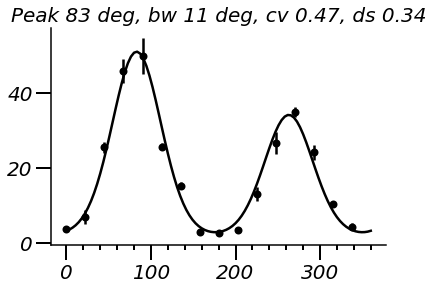

In [817]:
orivals, oriresps, oristderr = [ori['ori_exp'][x] for x in ['oriVals', 'counts_mean', 'counts_stderr']];
plt.errorbar(orivals, oriresps, oristderr, fmt='o', color='k');
# model                                                                                                                                                                                                                                                                       
plt_oris = np.linspace(0, 2*np.pi, 100);
mod_resp = ori['oriMod'](*prms, plt_oris)
plt.plot(np.rad2deg(plt_oris), mod_resp, 'k-');
plt.title('Peak %d deg, bw %d deg, cv %.2f, ds %.2f' % (ori['pref'], ori['bw'], ori['cv'], ori['DS']))
#ax[2, 0].legend();

In [811]:
oriResps, oriVals = ori['ori_exp']['counts_mean'], ori['ori_exp']['oriVals'];
oriAsRad = np.deg2rad(oriVals);
sigma = np.ones_like(oriAsRad);
k = 0.01
mod = ori['oriMod']

maxResp, baseline = np.max(oriResps), np.min(oriResps)

In [792]:
curr_obj = lambda params: np.sum(np.divide(np.square(oriResps - mod(*params, oriAsRad)), (k+np.square(sigma))));

In [793]:
ori['params']

array([41.38179017,  0.25706349,  1.49324832,  0.77835356,  2.64320652])

In [794]:
prms

array([46.        ,  0.25706349,  1.49324832,  0.7       ,  2.64320652])

In [795]:
curr_obj(prms)

128.20604957907528

In [796]:
curr_obj(ori['params'])

222.346828627118

In [607]:
ori['params']

array([0.95186438, 0.31862508, 0.70371571, 0.16296734, 0.        ])